# Conditional Expectation Regression with NCP (1D -> 1D)

This notebook trains a small Neural Conditional Probability (NCP) model on a 1D->1D toy dataset where the conditional distribution is:
- Unimodal and noisy for |x| <= 1 (expectation is meaningful and near the mode).
- Bimodal for 1 < |x| <= 2 (two symmetric modes; expectation is close to the middle with low probability).

We evaluate how well NCP learns a representation that supports accurate conditional expectation regression.

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import torch
from symm_learning.models import MLP
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from symm_rep_learn.models.ncp import NCP

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
plt.style.use("seaborn-v0_8-notebook")
FIG_SIZE = (3, 2)

# Paths
ROOT = pathlib.Path(os.getcwd())
PLOT_PATH = ROOT / "plots"
PLOT_PATH.mkdir(parents=True, exist_ok=True)

print(f"Using device: {DEVICE}")


EMBEDDING_DIM = 32
BATCH_SIZE = 2024

Using device: cuda


## Plotting utilities file (plotting.py)
We will use helper functions from `plotting.py` in this folder.

In [2]:
import sys

sys.path.append(os.getcwd())
from plotting import (
    LiveLossPlotter,
    plot_conditional_cdf_on_support,
    plot_expectations_with_quantiles,
    scatter_with_density,
)

## Synthetic dataset: unimodal center, bimodal edges
- For |x| <= 1: y = f_c(x) + eps1 with eps1 ~ N(0, 0.05)
- For 1 < |x| <= 2: y = s * a(x) + eps2 with s in {-1, 1} equally likely,
  a(x) = 0.5 + 0.8*(|x|-1), eps2 ~ N(0, 0.03).
True conditional expectation: f_c(x) for |x|<=1 and 0 for 1<|x|<=2.

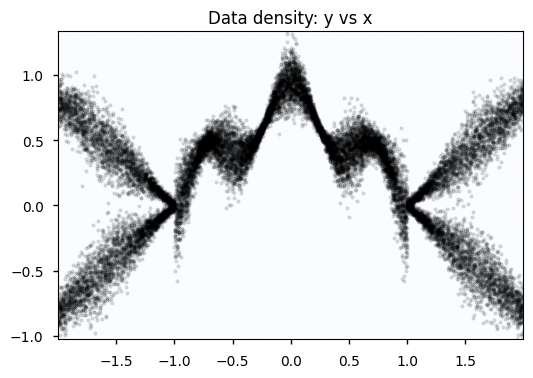

In [3]:
def f_center(x):
    return 0.5 * torch.cos(2 / 3 * math.pi * x) + 0.2 * torch.cos(4 * 2 / 3 * math.pi * x) + 0.25


def make_dataset(n=20000, seed=SEED, x=None):
    """Generate dataset (x, y). If x is provided, use it to condition the sampling.

    Args:
        n: number of samples to generate (ignored if x is an array with its own length)
        seed: RNG seed
        x: None (default, sample x ~ U[-2,2]); scalar (use a constant x for all samples);
           or array-like of shape (n,) or (n,1) providing the x's to use.
    """
    rng = np.random.default_rng(seed)

    # Build x according to the request
    if x is None:
        x_np = rng.uniform(-2.0, 2.0, size=(n, 1)).astype(np.float32)
    else:
        if np.isscalar(x):
            x_np = np.full((n, 1), float(x), dtype=np.float32)
        else:
            x_arr = np.asarray(x, dtype=np.float32)
            if x_arr.ndim == 1:
                x_arr = x_arr.reshape(-1, 1)
            assert x_arr.shape[1] == 1, f"x must be (n,) or (n,1), got {x_arr.shape}"
            # If provided x length disagrees with n, trust x's length
            if x_arr.shape[0] != n:
                n = x_arr.shape[0]
            x_np = x_arr

    x_t = torch.from_numpy(x_np)
    absx = torch.abs(x_t)

    # Heteroscedastic noise scales
    # Unimodal region |x|<=1: higher variance near |x|=1 and with oscillations
    sigma_uni = 0.02 + 0.06 * (absx**2) + 0.1 * torch.cos(2 * math.pi * x_t) ** 2
    # Bimodal region 1<|x|<=2: variance grows with distance from 1 and oscillates with |x|
    sigma_bi = 0.02 + 0.05 * (absx - 1.0).clamp(min=0) ** 2 + 0.1 * torch.sin(3 * absx) ** 2

    # Unimodal region |x|<=1
    eps1 = torch.randn_like(x_t) * sigma_uni
    y_uni = f_center(x_t) + eps1

    # Bimodal region 1<|x|<=2
    s = torch.from_numpy(rng.choice([-1.0, 1.0], size=(n, 1))).to(torch.float32)
    a = 0.8 * (absx - 1.0)
    eps2 = torch.randn_like(x_t) * sigma_bi
    y_bi = s * a + eps2

    y = torch.where(absx <= 1.0, y_uni, y_bi)
    return x_t, y


@torch.no_grad()
def true_condexp(x):
    x = torch.as_tensor(x, dtype=torch.float32)
    absx = torch.abs(x)
    y = torch.where(absx <= 1.0, f_center(x), torch.zeros_like(x))
    return y


# Generate full dataset
N = 20000
x, y = make_dataset(N)

# Quick preview plot
fig, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2))
scatter_with_density(x.numpy(), y.numpy(), ax=ax)
ax.set_title("Data density: y vs x")
plt.show()

## Split, standardize, and create DataLoaders

In [4]:
# Train/val/test split
idx = torch.randperm(x.shape[0])
train_end = int(0.7 * len(idx))
val_end = int(0.85 * len(idx))
idx_tr, idx_val, idx_te = idx[:train_end], idx[train_end:val_end], idx[val_end:]

x_tr, y_tr = x[idx_tr], y[idx_tr]
x_val, y_val = x[idx_val], y[idx_val]
x_te, y_te = x[idx_te], y[idx_te]

# Standardize using train stats
x_mean, x_std = x_tr.mean(0, keepdim=True), x_tr.std(0, keepdim=True) + 1e-8
y_mean, y_std = y_tr.mean(0, keepdim=True), y_tr.std(0, keepdim=True) + 1e-8

x_tr_c = (x_tr - x_mean) / x_std
y_tr_c = (y_tr - y_mean) / y_std
x_val_c = (x_val - x_mean) / x_std
y_val_c = (y_val - y_mean) / y_std
x_te_c = (x_te - x_mean) / x_std
y_te_c = (y_te - y_mean) / y_std

train_dl = DataLoader(TensorDataset(x_tr_c, y_tr_c), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(TensorDataset(x_val_c, y_val_c), batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(TensorDataset(x_te_c, y_te_c), batch_size=BATCH_SIZE, shuffle=False)

print("Standardization done.")

Standardization done.


## Baseline: MLP trained with MSE (same architecture and training config)

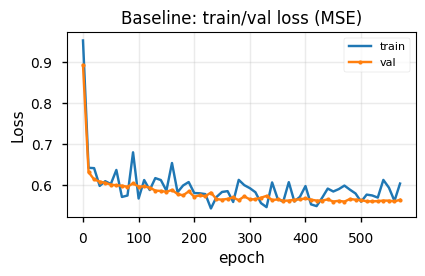

Training Baseline MLP:  57%|█████▋    | 570/1000 [00:35<00:26, 16.07it/s, train_loss=0.603, val_mse=0.563]

Early stopping baseline at epoch 570


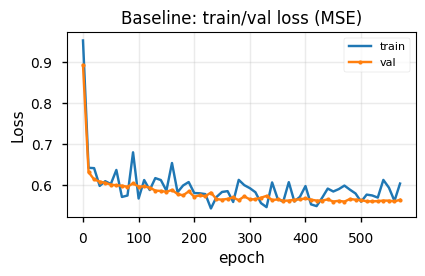

Baseline best val MSE: 0.55868


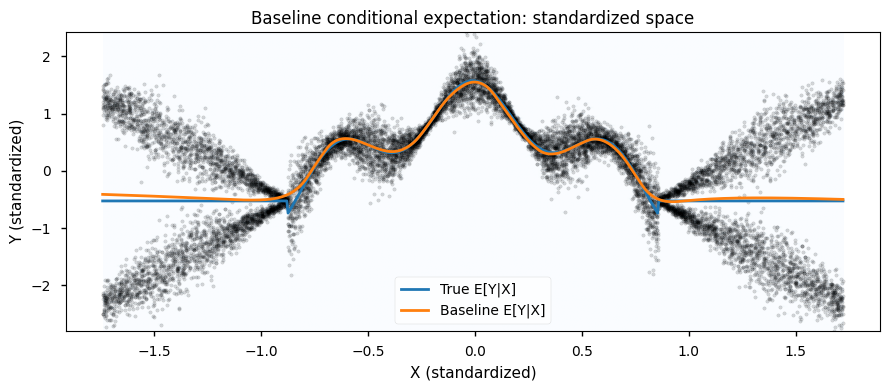

In [5]:
baseline_mlp = MLP(
    in_dim=1,
    out_dim=1,
    hidden_units=[EMBEDDING_DIM * 2] * 2 + [EMBEDDING_DIM] * 2,
    activation=torch.nn.ELU(),
    bias=True,
).to(DEVICE)
print(baseline_mlp)
opt_base = torch.optim.Adam(baseline_mlp.parameters(), lr=1e-3)

# Match training hyperparams between baseline and NCP
EPOCHS = 1000
CHECK_EVERY = 10
PATIENCE = 10
PLOT_FREQ = 50  # update live plot every N epochs


@torch.no_grad()
def val_mse(model, dl):
    model.eval()
    tot, n = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        tot += torch.mean((pred - yb) ** 2).item()
        n += 1
    return tot / max(1, n)


best_val = float("inf")
pat = 0
best_state = baseline_mlp.state_dict()

pbar = tqdm(range(EPOCHS), desc="Training Baseline MLP")
plotter_base = LiveLossPlotter(title="Baseline: train/val loss (MSE)", plot_freq=PLOT_FREQ)
for epoch in pbar:
    baseline_mlp.train()
    for xb, yb in train_dl:  # same BATCH_SIZE as defined earlier
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt_base.zero_grad()
        pred = baseline_mlp(xb)
        loss = torch.mean((pred - yb) ** 2)
        loss.backward()
        opt_base.step()

    if epoch % CHECK_EVERY == 0 or epoch == EPOCHS - 1:
        vm = val_mse(baseline_mlp, val_dl)
        pbar.set_postfix(train_loss=loss.item(), val_mse=vm)
        # live update at val check (forces redraw regardless of freq)
        plotter_base.update(epoch, train_loss=float(loss.item()), val_loss=float(vm), force=True)
        if vm < best_val:
            best_val = vm
            best_state = {k: v.cpu() for k, v in baseline_mlp.state_dict().items()}
            pat = 0
        else:
            pat += 1
            if pat >= PATIENCE:
                print(f"Early stopping baseline at epoch {epoch}")
                break

baseline_mlp.load_state_dict(best_state)
plotter_base.close()
print(f"Baseline best val MSE: {best_val:.5f}")


@torch.no_grad()
def baseline_predict(x_in):
    baseline_mlp.eval()
    return baseline_mlp(x_in.to(DEVICE)).cpu()


# Baseline-only conditional expectation plot (standardized space)
x_grid = torch.linspace(-2.0, 2.0, 600).reshape(-1, 1)
x_grid_c = (x_grid - x_mean) / x_std

with torch.no_grad():
    y_true_c = (true_condexp(x_grid) - y_mean) / y_std
    y_base_c = baseline_predict(x_grid_c)

# Use the plotting utility to render expectations (no quantiles here)
expectations_baseline = {
    "True E[Y|X]": y_true_c.numpy().ravel(),
    "Baseline E[Y|X]": y_base_c.numpy().ravel(),
}
fig, ax = plot_expectations_with_quantiles(
    x_train=x_tr_c.numpy().ravel(),
    y_train=y_tr_c.numpy().ravel(),
    x_grid=x_grid_c.numpy().ravel(),
    expectations=expectations_baseline,
    true_quantiles=None,
    est_quantiles=None,
    figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1] * 2),
)
ax.set_title("Baseline conditional expectation: standardized space")
fig.tight_layout()
fig.savefig(PLOT_PATH / "baseline_condexp_full.png", dpi=200)
plt.show()

## NCP model (after baseline)

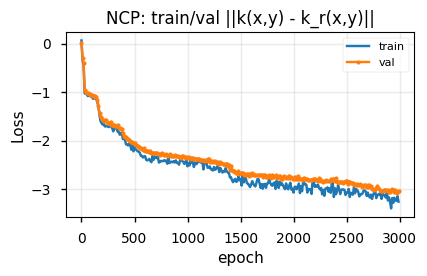

Training NCP: 100%|██████████| 3000/3000 [05:38<00:00,  8.87it/s, loss=-3.23, val=-3]


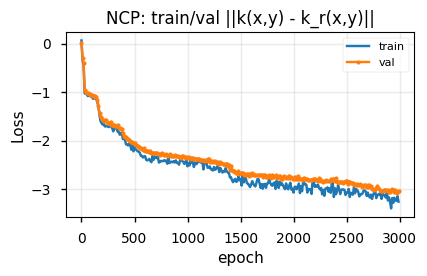

NCP best val objective: -3.03843


In [6]:
from symm_rep_learn.nn.layers import ResidualEncoder

BATCH_NORM = False
ORTH_REG = 0.01
CENTERING_REG = 0.00
MOMENTUM = 0.999
ncp = NCP(
    embedding_x=ResidualEncoder(
        MLP(
            in_dim=1,
            out_dim=EMBEDDING_DIM,
            hidden_units=[EMBEDDING_DIM * 2] * 2,
            activation=torch.nn.ELU(),
            bias=True,
            batch_norm=BATCH_NORM,
        ),
        in_dim=1,
    ),
    embedding_y=ResidualEncoder(
        MLP(
            in_dim=1,
            out_dim=EMBEDDING_DIM,
            hidden_units=[EMBEDDING_DIM * 2] * 2,
            activation=torch.nn.ELU(),
            bias=True,
            batch_norm=BATCH_NORM,
        ),
        in_dim=1,
    ),
    embedding_dim_x=EMBEDDING_DIM + 1,
    embedding_dim_y=EMBEDDING_DIM + 1,
    orth_reg=ORTH_REG,
    centering_reg=CENTERING_REG,
    momentum=MOMENTUM,
).to(DEVICE)

print(ncp)

# Train NCP with early stopping on validation negative loss (the lower, the better)
CHECK_EVERY = 10
PATIENCE = 50
NCP_LR = 1e-3
optimizer = torch.optim.Adam(ncp.parameters(), lr=NCP_LR)


@torch.no_grad()
def val_objective(ncp_model, dl):
    metrics = {}
    ncp_model.eval()
    tot, n = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        fx, hy = ncp_model(xb, yb)
        loss, batch_metrics = ncp_model.loss(fx, hy)
        tot += float(loss.item())
        n += 1

        # Update metrics with batch values
        for k, v in batch_metrics.items():
            if k in metrics:
                metrics[k].append(v)
            else:
                metrics[k] = [v]
    # Average the metrics across the batch
    for k, v in metrics.items():
        metrics[k] = np.mean(v)

    return tot / max(1, n), metrics


best_val = float("inf")
pat = 0
best_state = ncp.state_dict()


pbar = tqdm(range(3 * EPOCHS), desc="Training NCP")
VAL_METRIC = "||k(x,y) - k_r(x,y)||"
plotter_ncp = LiveLossPlotter(title=f"NCP: train/val {VAL_METRIC}", plot_freq=PLOT_FREQ)
for epoch in pbar:
    ncp.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        fx, hy = ncp(xb, yb)
        loss, metrics = ncp.loss(fx, hy)
        loss.backward()
        optimizer.step()

    if epoch % CHECK_EVERY == 0 or epoch == EPOCHS - 1:
        vm, val_metrics = val_objective(ncp, val_dl)
        pbar.set_postfix(loss=float(loss.item()), val=vm)
        # live update at val check (forces redraw regardless of freq)
        plotter_ncp.update(
            epoch, train_loss=float(metrics[VAL_METRIC]), val_loss=float(val_metrics[VAL_METRIC]), force=True
        )
        if vm < best_val:
            best_val = vm
            best_state = {k: v.cpu() for k, v in ncp.state_dict().items()}
            pat = 0
        else:
            pat += 1
            if pat >= PATIENCE:
                print(f"Early stopping NCP at epoch {epoch}")
                break


ncp.load_state_dict(best_state)
ncp.eval()
plotter_ncp.close()
print(f"NCP best val objective: {best_val:.5f}")

## CCDF comparison at unimodal and bimodal x
We compare the predicted conditional CDF (NCP) against a numerically estimated ground truth CCDF (by sampling from the known generative process) and the marginal CDF, for two conditioning values: one in the unimodal region and one in the bimodal region.

## Visualize conditional expectation vs ground truth

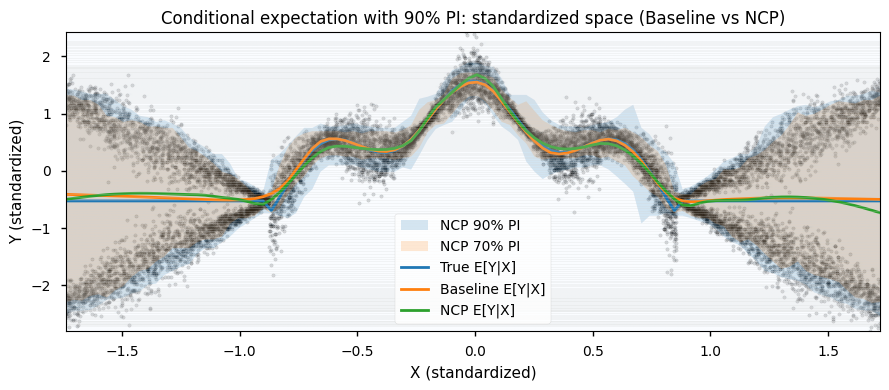

In [12]:
SEED = 42
ncp.eval()
# Set seed
torch.manual_seed(SEED)
np.random.seed(SEED)
RIDGE_REG = 1e-2
# Fit the built-in linear decoder to map h(y) -> y (standardized)
dec_dl = DataLoader(TensorDataset(y_tr_c, y_tr_c), batch_size=BATCH_SIZE, shuffle=False)
linear_decoder = ncp.fit_linear_decoder(train_dataloader=dec_dl, ridge_reg=RIDGE_REG, lstsq=False)


# Build NCP Conditional CDF helper and 90% quantiles for y (support is in standardized y-space)
from plotting import plot_expectations_with_quantiles

from symm_rep_learn.inference.ncp import NCPConditionalCDF

ALPHA = 0.10  # 90% coverage
ncp_ccdf = NCPConditionalCDF(
    model=ncp,
    y_train=y_tr_c,
    support_discretization_points=200,
    ridge_reg=RIDGE_REG,
    support_strategy="quantile_transformer",
    discretizer_kwargs=dict(random_state=int(SEED), subsample=None, u_eps=1e-5, output_distribution="normal"),
)

# Build dense grid on standardized x (do NOT use y support for x)
x_grid = torch.linspace(x_tr.min().item(), x_tr.max().item(), 100).reshape(-1, 1)
x_grid_c = (x_grid - x_mean) / x_std

with torch.no_grad():
    y_true_c = (true_condexp(x_grid) - y_mean) / y_std
    y_base_c = baseline_predict(x_grid_c)
    y_pred_c = ncp.conditional_expectation(x=x_grid_c.to(DEVICE), hy2zy=linear_decoder).cpu()
    # NCP 90% prediction interval (standardized y-space)

quantiles = {}
for alpha in [0.10, 0.30]:
    q_lo_ncp, q_up_ncp = ncp_ccdf.conditional_quantiles(x_cond=x_grid_c, alpha=alpha)
    quantiles[alpha] = (q_lo_ncp, q_up_ncp)

# Prepare inputs for the helper
expectations = {
    "True E[Y|X]": y_true_c.numpy().ravel(),
    "Baseline E[Y|X]": y_base_c.numpy().ravel(),
    "NCP E[Y|X]": y_pred_c.numpy().ravel(),
}
# est_quantiles = { f"NCP {(1-ALPHA)*100:.0f}% PI": (np.asarray(q_lo_ncp).ravel(), np.asarray(q_up_ncp).ravel()) }
est_quantiles = {}
for alpha, (q_lo_ncp, q_up_ncp) in quantiles.items():
    est_quantiles[f"NCP {(1 - alpha) * 100:.0f}% PI"] = (np.asarray(q_lo_ncp).ravel(), np.asarray(q_up_ncp).ravel())

fig, ax = plot_expectations_with_quantiles(
    x_train=x_tr_c.numpy().ravel(),
    y_train=y_tr_c.numpy().ravel(),
    x_grid=x_grid_c.numpy().ravel(),
    expectations=expectations,
    est_quantiles=est_quantiles,
    true_quantiles=None,
    figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1] * 2),
)
# Overlay horizontal lines at discretized y-support (standardized space)
support_std = np.asarray(ncp_ccdf.discretized_support).squeeze().ravel()
xmin, xmax = float(np.min(x_grid_c.numpy())), float(np.max(x_grid_c.numpy()))
ax.hlines(support_std, xmin, xmax, colors="lightgray", alpha=0.25, lw=0.6)

ax.set_title("Conditional expectation with 90% PI: standardized space (Baseline vs NCP)")
fig.tight_layout()
fig.savefig(PLOT_PATH / "condexp_full_comparison_with_quantiles.png", dpi=200)
plt.show()

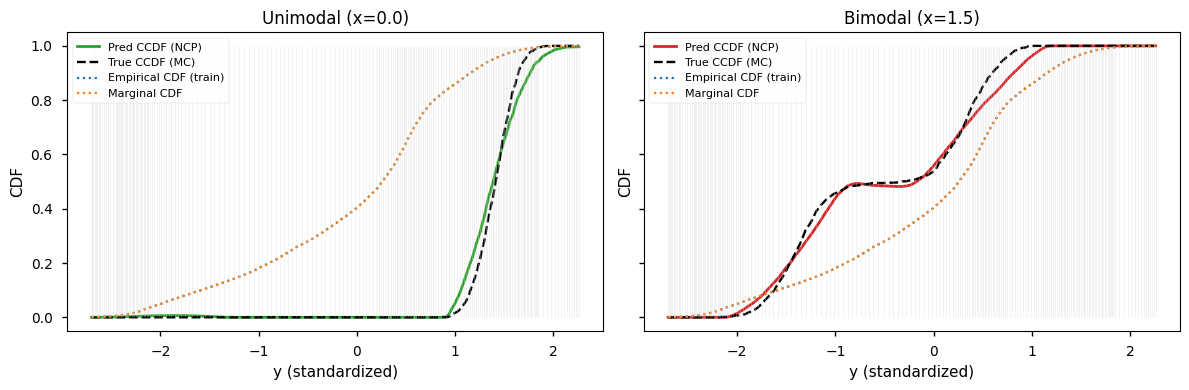

In [13]:
# Choose conditioning values: one unimodal (|x|<=1), one bimodal (1<|x|<=2)
x_vals = torch.tensor([0.1, 1.5], dtype=torch.float32).reshape(-1, 1)  # adjust as desired
labels = ["Unimodal (x=0.0)", "Bimodal (x=1.5)"]
colors = ["tab:green", "tab:red"]

# Support (standardized y-space) and model marginal CDF on that support
discretized_support = np.asarray(ncp_ccdf.discretized_support).squeeze().ravel()
model_marginal = np.asarray(ncp_ccdf.marginal_CDF).squeeze().ravel()

# Build empirical marginal CDF from training targets (standardized space)
y_all = y_tr_c.squeeze().cpu().numpy()
y_all_sorted = np.sort(y_all)

# Prepare predicted CCDFs and ground-truth CCDFs evaluated exactly on the support
ccdf_series = []
gt_series = []
for i, x0 in enumerate(x_vals):
    x0_c = ((x0 - x_mean) / x_std).to(DEVICE)
    pred = ncp_ccdf(x_cond=x0_c)
    pred = np.asarray(pred).squeeze().ravel()  # ensure 1D aligned with support
    ccdf_series.append(pred)

    # Ground-truth CCDF by sampling via make_dataset at fixed x, then standardize and evaluate at support
    _, y_samp = make_dataset(n=1000, seed=SEED + i, x=float(x0.item()))
    y_samp_c = ((y_samp - y_mean) / y_std).squeeze().cpu().numpy()
    y_samp_sorted = np.sort(y_samp_c)
    gt_cdf = np.searchsorted(y_samp_sorted, discretized_support, side="right") / len(y_samp_sorted)
    gt_series.append(gt_cdf)

# Plot per-x using the helper that respects support and adds vlines
fig, axs = plt.subplots(1, len(x_vals), figsize=(FIG_SIZE[0] * 4, FIG_SIZE[1] * 2), sharey=True)
axs = np.atleast_1d(axs)
for i, (c_pred, c_gt, lab, col) in enumerate(zip(ccdf_series, gt_series, labels, colors)):
    plot_conditional_cdf_on_support(
        discretized_support,
        c_pred,
        ax=axs[i],
        label_pred="Pred CCDF (NCP)",
        color_pred=col,
        y_train=y_tr_c,  # empirical marginal overlay
        model_marginal_cdf=model_marginal,  # model marginal overlay
        gt_ccdf=c_gt,
        label_gt="True CCDF (MC)",
        color_gt="black",
        ls_gt="--",
    )
    axs[i].set_title(lab)
    if i == 0:
        axs[i].set_ylabel("CDF")

fig.tight_layout()
fig.savefig(PLOT_PATH / "ccdf_unimodal_bimodal_compare.png", dpi=250)
plt.show()

## Metrics comparison: Baseline vs NCP

In [14]:
# 90% coverage evaluation for NCP on test set (standardized space)
@torch.no_grad()
def coverage_and_size_ncp(ccdf_model, dl, alpha):
    ccdf_model.eval()
    cov = 0.0
    size = 0.0
    n = 0
    for xb, yb in dl:
        q_lo, q_up = ccdf_model.conditional_quantiles(x_cond=xb, alpha=alpha)
        q_lo = torch.as_tensor(q_lo, dtype=torch.float32)
        q_up = torch.as_tensor(q_up, dtype=torch.float32)
        inside = ((q_lo <= yb) & (yb <= q_up)).float().mean()
        seg = (q_up - q_lo).abs().mean()
        cov += inside.item()
        size += seg.item()
        n += 1
    return cov / max(n, 1), size / max(n, 1)


for alpha in [0.10, 0.20, 0.30, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    cov, size = coverage_and_size_ncp(ncp_ccdf, test_dl, alpha)
    print(f"NCP empirical coverage: {cov * 100:.2f}% - desired: {(1 - alpha) * 100:.0f}% | CI size: {size:.3f}")

NCP empirical coverage: 92.80% - desired: 90% | CI size: 1.623
NCP empirical coverage: 85.60% - desired: 80% | CI size: 1.412
NCP empirical coverage: 76.88% - desired: 70% | CI size: 1.266
NCP empirical coverage: 66.37% - desired: 60% | CI size: 1.085
NCP empirical coverage: 55.12% - desired: 50% | CI size: 0.596
NCP empirical coverage: 45.92% - desired: 40% | CI size: 0.396
NCP empirical coverage: 35.18% - desired: 30% | CI size: 0.280
NCP empirical coverage: 22.79% - desired: 20% | CI size: 0.181
NCP empirical coverage: 11.98% - desired: 10% | CI size: 0.101
